In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


# 1. Introduction

## 1.1 About the project

The goal of this project is to develop a model for predicting wheteher or not an applicant will be approved for a bank loan. The project is carried out as part of [Kaggle Playground Series Season 4 Episode 10](https://www.kaggle.com/competitions/playground-series-s4e10/overview) and as part of my journey of learning data science and machine learning.

In this project, I will explore the data to discover the quirks of this specific dataset, by analyzing summary statistics, distributions of numerical and categorical variable, as well as correlations between features.

Next, I will prepare the data for modeling, which includes encoding features and imputing missing values. Since we are working with a synthetic dataset, I will not be performing any feature engineering.

I will construct 4 different classifiers, `GradientBoostingClassifier`, `XGBoostClassifier`, `LightGBMClassifier` and `CatBoostClassifier`, all of which are based on gradient boosting decision trees. These models are efficient for performing classification tasks. 

To optimize the performance of the models, I will use Optuna to tune hyperparameters. The model performance will be evaluated using 5-fold cross-validation. Since the target variable is unevenly distributed, I will use `StratifiedKFold` to keep this relationship when performing the splits into folds.

I will compare the performance of the individual models, and create an ensemble model combining the predictions of the models using hill climbing. The models will be evaluated based on the area under the receiver operating characteristics (ROC) curve, or AUC for short. The ROC is the plot of the true positive rate versus the false positive rate, which is indicative of the performance of a binary classifier. A perfect model would yield an AUC of 1.0 and a bad model would likely be close to an AUC of 0.5, which is as good as guessing.

## 1.2 About the data

The datasets provided for this competition consist of a training and test set. Thes have been generated from a deep learning model trained on the original data from [Loan Approval Prediction](https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction). We will also be including the original dataset in the analysis. The features of the datasets are the following:

Target variable - `loan_status` - binary (0,1)

Numerical features:

* `person_age`
* `person_income`
* `person_emp_length`
* `loan_amnt`
* `loan_int_rate`
* `loan_percent_income`
* `cb_person_cred_hist_length`

Categorical features:

* `person_home_ownership`
* `loan_intent`
* `loan_grade`
* `cb_person_default_on_file`

# 2. Importing libraries

In [15]:
!pip install -q hillclimbers

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from scipy.special import logit
from hillclimbers import climb_hill, partial
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import optuna
from optuna.samplers import TPESampler

# 3. Loading and understanding the data

In [17]:
class Config:
    train_path = "/kaggle/input/playground-series-s4e10/train.csv"
    test_path = "/kaggle/input/playground-series-s4e10/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s4e10/sample_submission.csv"
    original_data_path = "/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv"
    
    target = "loan_status"
    n_folds = 5
    seed = 42

In [18]:
train = pd.read_csv(Config.train_path, index_col="id")
test = pd.read_csv(Config.test_path, index_col="id")

print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (58645, 12)
Test shape: (39098, 11)


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.8+ MB


In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [21]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


In [22]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,39098.0,27.566781,6.032761,20.00,23.00,26.00,30.00,94.00
person_income,39098.0,64060.460842,37955.828705,4000.00,42000.00,58000.00,75885.00,1900000.00
person_emp_length,39098.0,4.687068,3.868395,0.00,2.00,4.00,7.00,42.00
loan_amnt,39098.0,9251.466188,5576.254680,700.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,39098.0,10.661216,3.020220,5.42,7.88,10.75,12.99,22.11
loan_percent_income,39098.0,0.159573,0.091633,0.00,0.09,0.14,0.21,0.73
cb_person_cred_hist_length,39098.0,5.830707,4.072157,2.00,3.00,4.00,8.00,30.00


In [23]:
categorical_features = train.select_dtypes(include=["object"]).columns.tolist()
unique_values = {col: train[col].nunique() for col in categorical_features}
for col, value in unique_values.items():
    print(f"{col}: {value} unique values")

person_home_ownership: 4 unique values
loan_intent: 6 unique values
loan_grade: 7 unique values
cb_person_default_on_file: 2 unique values


## 3.1 First observations

* The training data contains 58645 entries, meaning that it's a relatively small dataset. We could try a simpler model and see how it compares to XGBoost.

* The data doesn't contain any missing values

* Most of the columns are numerical. The ranges of values differs by orders of magnitude for the different features. To optimize model performance, scaling the features would be useful.

* The mean and the median is similar for most features, indicating that there's not a lot of extreme values. However, there seems to be some extreme values. Let's explore outliers further later on.

* There are relatively few unique values for the categorical features, meaning that regardless of the type of encoding, there won't be a huge number of columns added. We can experiment with OneHot encoding or label encoding.

# 4. Exploratory Data Analysis

## 4.1 The target variable

As can be seen from the countplot below, the target variable is binary and unbalanced. We need to account for that whenever we split the data.

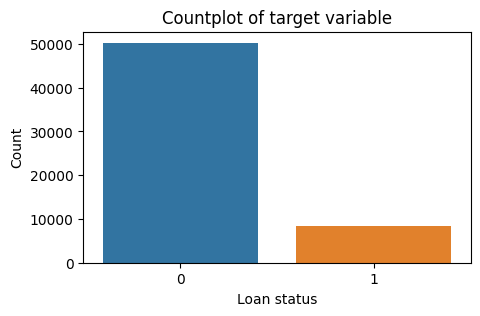

In [24]:
plt.figure(figsize=(5,3))
sns.countplot(data=train, x=Config.target)
plt.title("Countplot of target variable")
plt.xlabel("Loan status")
plt.ylabel("Count")
plt.show()

In [25]:
train["loan_status"].value_counts(normalize=True).round(3).astype(str) + "%"

loan_status
0    0.858%
1    0.142%
Name: proportion, dtype: object

## 4.2 Exploring Numerical Features

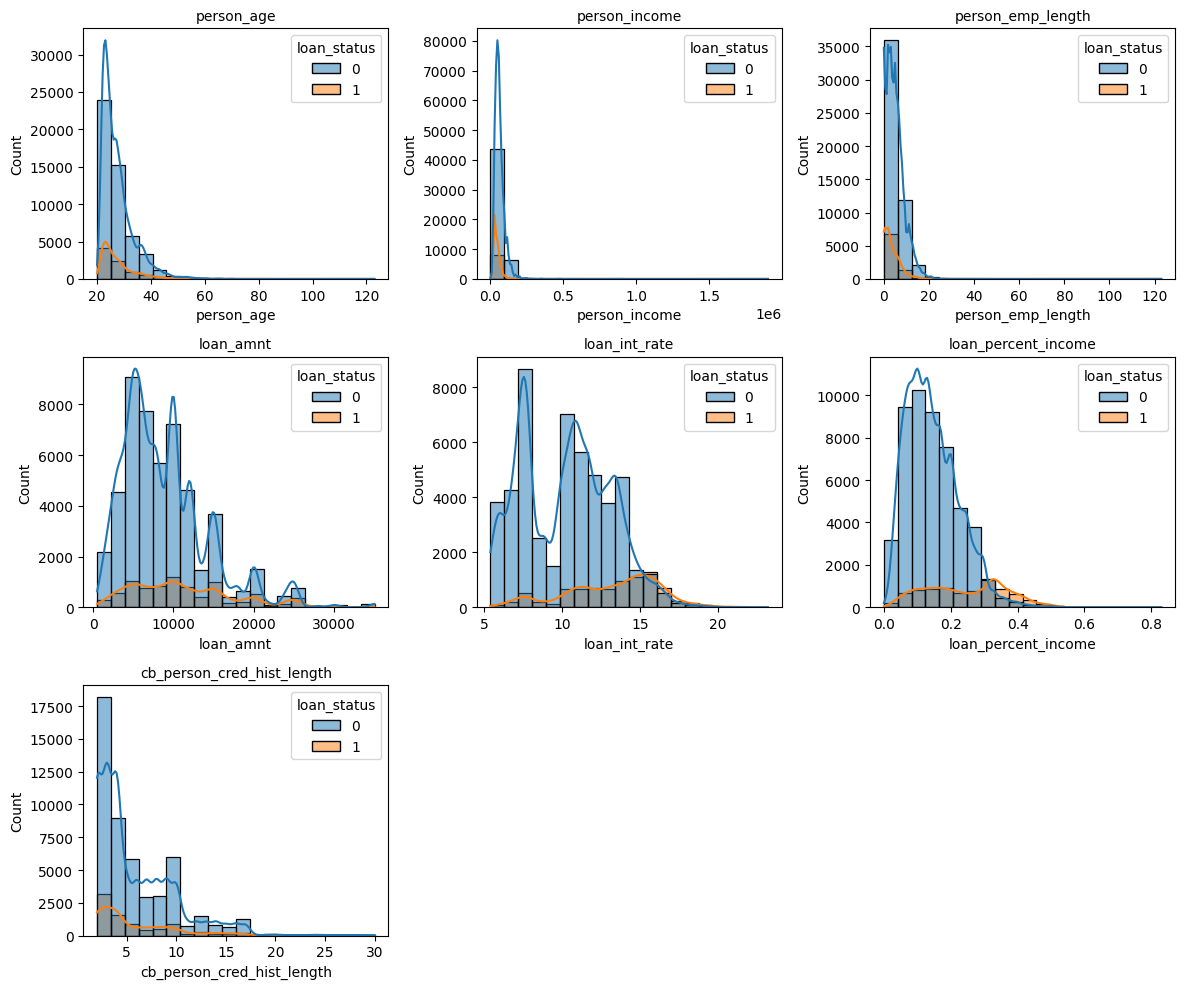

In [26]:
numerical_features = train.select_dtypes(exclude=["object"]).columns.tolist()
fig, axs = plt.subplots(3, 3, figsize=(12,10))

for feat, ax in zip(numerical_features, axs.ravel()):
    sns.histplot(x=feat, hue=Config.target, data=train, kde=True, bins=20, ax=ax)
    ax.set_title(f"{feat}", fontsize=10)
    
# Remove the last two unused subplots
for i in range(7, 9):
    fig.delaxes(axs.ravel()[i])

plt.tight_layout()
plt.show()

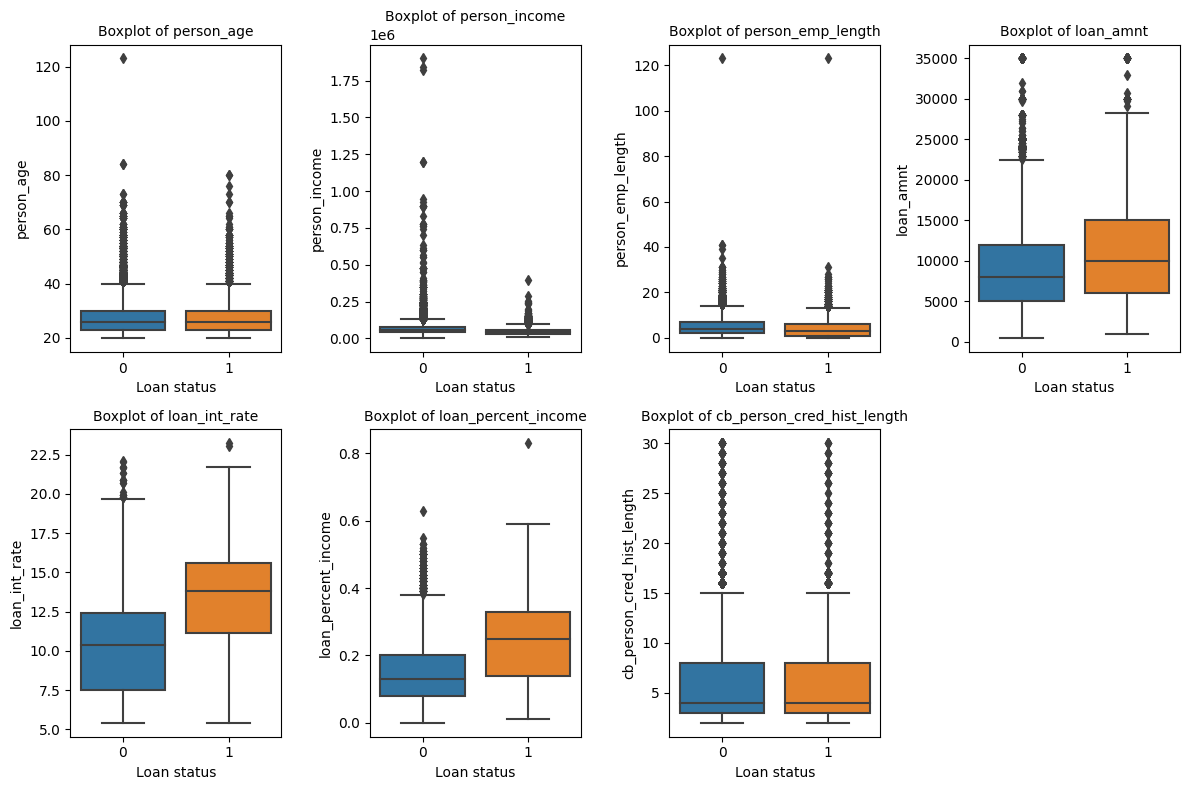

In [27]:
fig, axs = plt.subplots(2,4, figsize=(12, 8))

for feat, ax in zip(numerical_features, axs.ravel()):
    sns.boxplot(x=Config.target, y=feat, data=train, ax=ax)
    ax.set_title(f"Boxplot of {feat}", size=10)
    ax.set_xlabel("Loan status")


fig.delaxes(axs.ravel()[7])
plt.tight_layout()
plt.show()

In [28]:
def detect_outliers(df, column):
    Q1 = np.quantile(df[column], 0.25)
    Q3 = np.quantile(df[column], 0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    
    return df[(df[column] < lower_limit) | (df[column] > upper_limit)]

for feat in numerical_features:
    outliers = detect_outliers(train, feat)
    print(f"Outliers in column {feat}: {outliers.shape[0]}")

Outliers in column person_age: 2446
Outliers in column person_income: 2411
Outliers in column person_emp_length: 1274
Outliers in column loan_amnt: 2045
Outliers in column loan_int_rate: 34
Outliers in column loan_percent_income: 1210
Outliers in column cb_person_cred_hist_length: 1993
Outliers in column loan_status: 8350


As can be seen above, there are quite a few outliers in most of the columns, so we should consider how to deal with them. Some possible approaches are:

* Remove outliers: This approach would be suitable if we have a small number of outliers and/or if the outlier values are errors. In our case, since the dataset is relatively small and the number of outliers is relatively large, we'll refrain from removing any outliers in order to not reduce the size of the dataset.

* Cap outliers: Limit extreme values by capping them at a maximum threshold

* Log Transformation: For features with highly skewed distributions, applying a log or similar transformation can reduce the influence of extreme values.

Since we are planning to use tree-based models, we'll construct the initial models without handling outliers but can return to this later if necessary.

Additionally, as mentioned above, the ranges of values differs by several orders of magnitude. We could consider using StandardScaler(), which centers the data around 0 by subtracting the mean and scales the distribution to have a standard deviation of 1 by dividing by the standard deviation. However, tree-based methods are not based on distance or gradient magnitude, rendering scaling unnecessary. 

## 4.2.1 Exploring correlations between numerical features

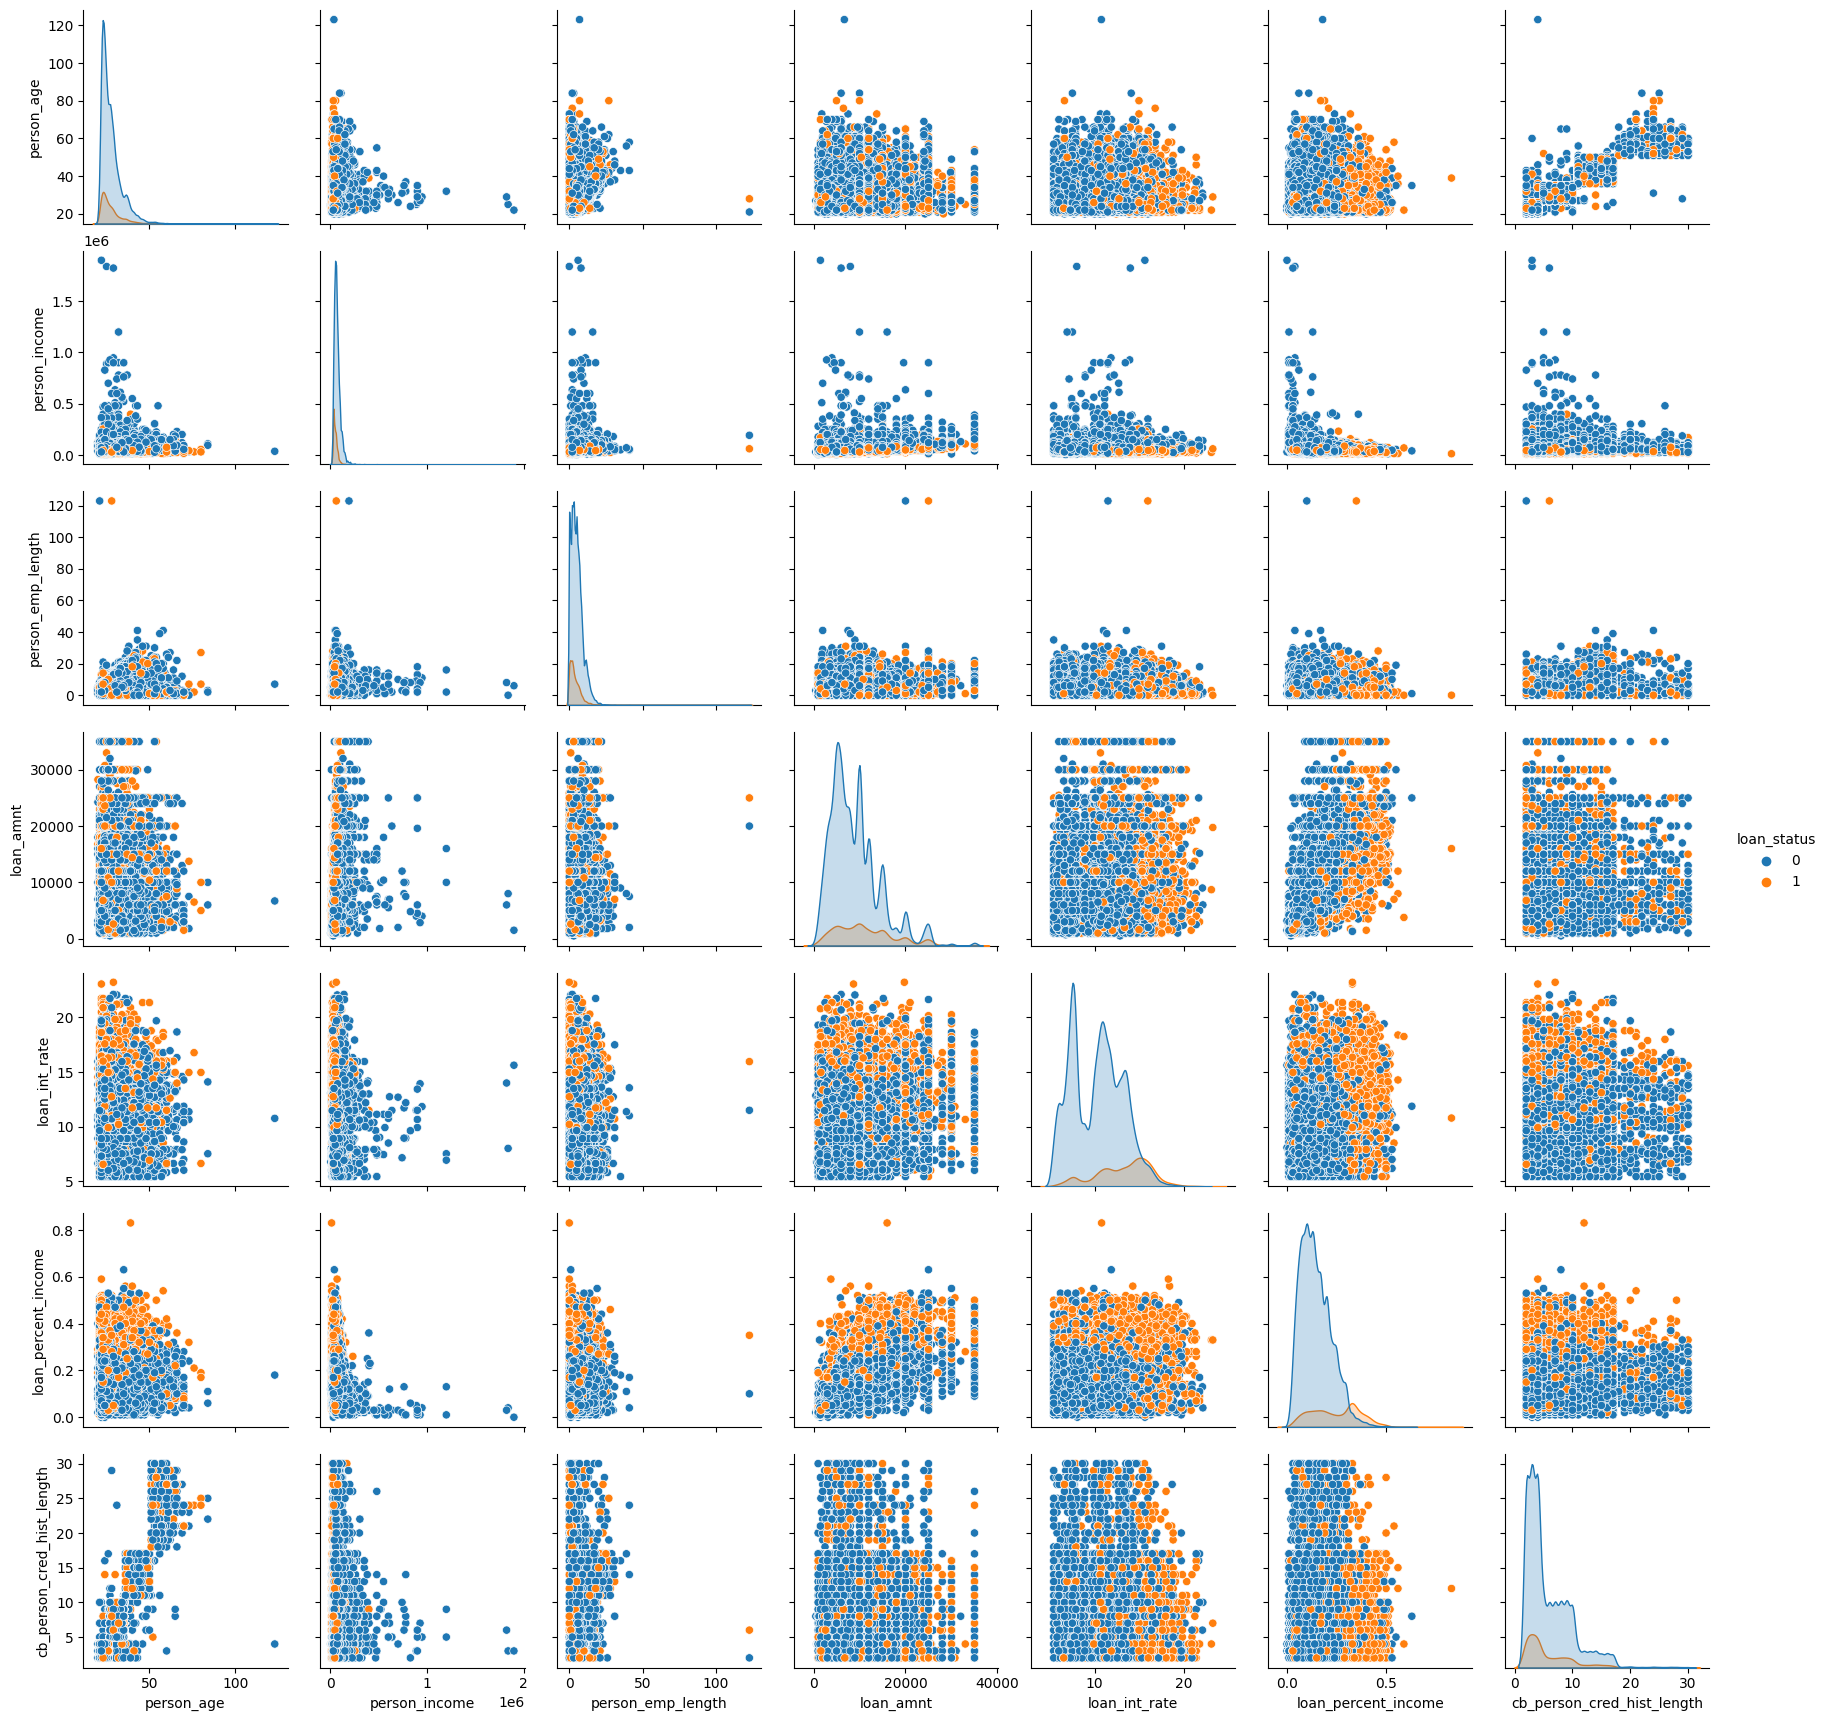

In [29]:
columns_to_plot = train.select_dtypes(exclude=["object"]).columns.tolist()
sns.pairplot(train[columns_to_plot], hue=Config.target)
plt.show()

## 4.3 Exploring categorical features

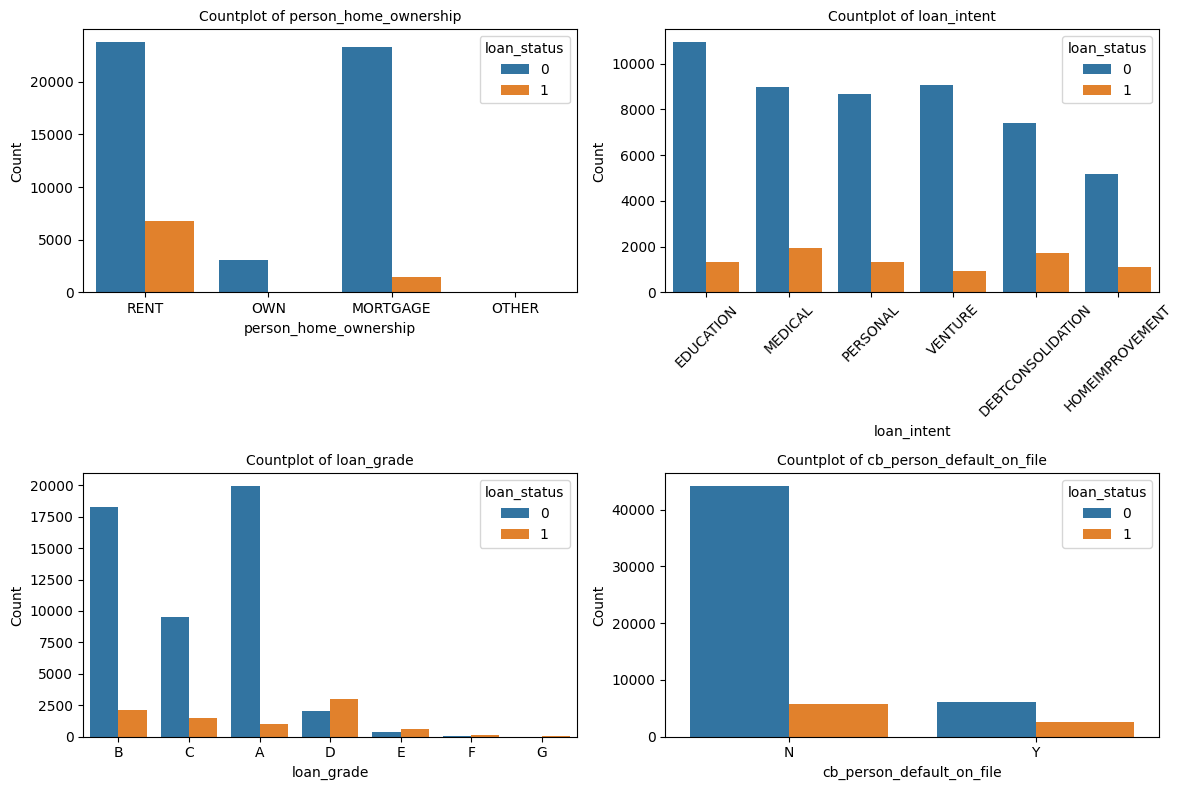

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

for feat, ax in zip(categorical_features, axs.ravel()):
    sns.countplot(data=train, x=feat, hue=Config.target, ax=ax)
    ax.set_title(f"Countplot of {feat}", size=10)
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")
    if feat == "loan_intent":
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
plt.tight_layout()
plt.show()

# 5. Data Processing

In [31]:
def process_data(impute_missing=False, is_for_catboost=False, use_encoding=False):
    
    # Read the datasets
    train = pd.read_csv(Config.train_path, index_col="id")
    test = pd.read_csv(Config.test_path, index_col="id")
    original = pd.read_csv(Config.original_data_path)
    
    # Impute missing values (only for original dataset)
    if impute_missing:
        original["person_emp_length"] = original["person_emp_length"].fillna(original["person_emp_length"].median())
        original["loan_int_rate"] = original["loan_int_rate"].fillna(original["loan_int_rate"].median())
        
    # Define categorical features
    if is_for_catboost:
        categorical_columns = test.columns.tolist()
    else:
        categorical_columns = test.select_dtypes(include=["object"]).columns.tolist()
        
    # Convert categorical columns to 'category' type
    train[categorical_columns] = train[categorical_columns].astype(str).astype("category")
    test[categorical_columns] = test[categorical_columns].astype(str).astype("category")
    original[categorical_columns] = original[categorical_columns].astype(str).astype("category")
        
    if use_encoding:
        encoder = OrdinalEncoder()
        train[categorical_columns] = encoder.fit_transform(train[categorical_columns])
        test[categorical_columns] = encoder.transform(test[categorical_columns])
        original[categorical_columns] = encoder.transform(original[categorical_columns])
        
    # Divide data into X and y sets
    X = train.drop(Config.target, axis=1)
    y = train[Config.target]
    X_test = test
    
    X_original = original.drop(Config.target, axis=1)
    y_original = original[Config.target]
    
    if is_for_catboost:
        return X, y, X_test, X_original, y_original, categorical_columns
    else:
        return X, y, X_test, X_original, y_original
    
    

## 5.1 Analyze mutual information and correlation to check the dependence of features

In [32]:
X_mi, y_mi, _, _, _ = process_data(use_encoding=True)

mutual_info = mutual_info_classif(X_mi, y_mi, random_state=Config.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X_mi.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=["Mutual Information"])
mutual_info.style.bar(subset=["Mutual Information"], cmap="RdYlGn")

,Mutual Information
person_income,0.097826
loan_int_rate,0.084167
loan_percent_income,0.082536
loan_grade,0.080511
person_home_ownership,0.041433
loan_amnt,0.016160
cb_person_default_on_file,0.014135
person_emp_length,0.008371
loan_intent,0.006237
cb_person_cred_hist_length,0.001656


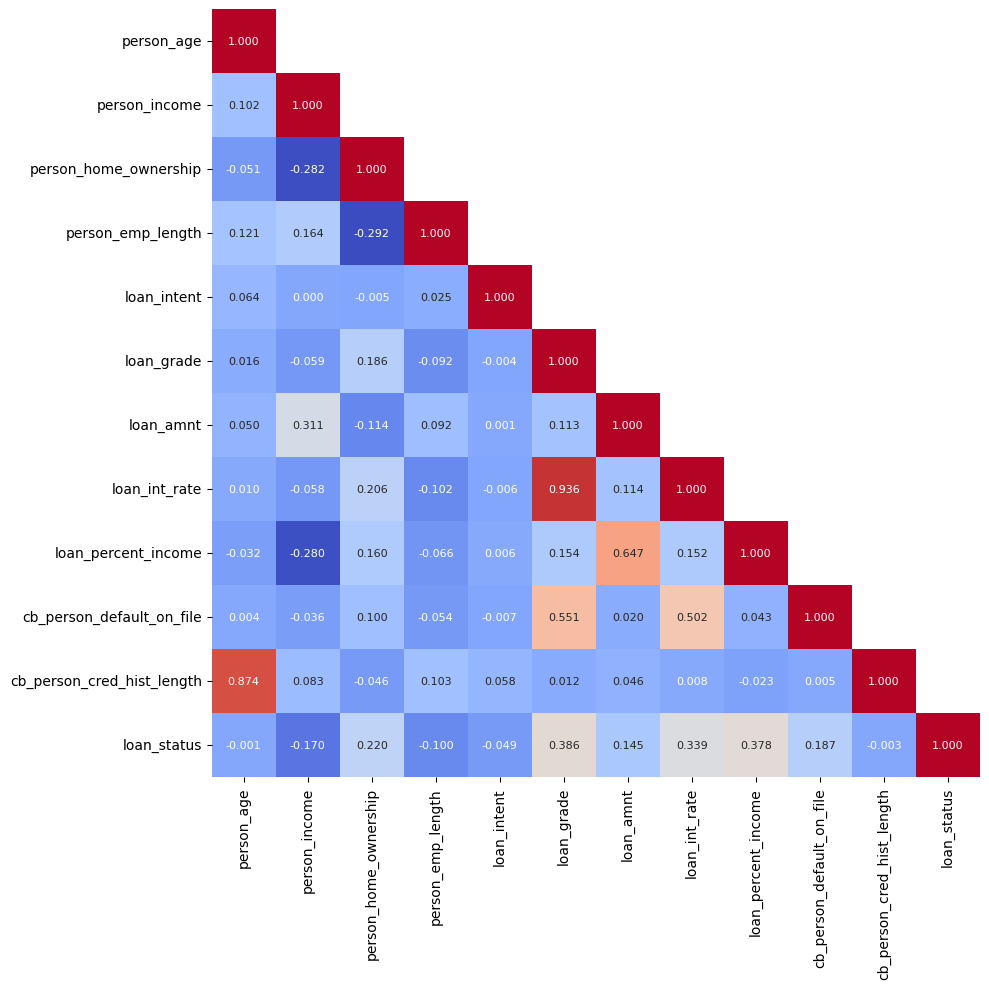

In [33]:
plt.figure(figsize=(10,10))

corr_train = pd.concat([X_mi, y_mi], axis=1).corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(data=corr_train,
           annot=True,
           fmt=".3f",
           mask=mask_train,
           cmap="coolwarm",
           annot_kws={"size": 8},
           cbar=False)

plt.tight_layout()
plt.show()

From both the mutual information and the correlation plots, we can see that the features `person_age` and `cb_person_cred_inst_length` has carries little value in terms of the influence of the target variable. However, since they do carry some information, we'll keep them.

# 6. Machine Learning

## 6.1 Tuning hyperparameters using Optuna 

In [34]:
def objective(trial, model, is_catboost=False, is_gradient_boosting=False):
    # Load the data
    if is_catboost:
        X, y, _, X_original, y_original, categorical_features = process_data(impute_missing=True, is_for_catboost=True),
    elif is_gradient_boosting:
        X, y, _, X_original, y_original = process_data(impute_missing=True, use_encoding=True)
    else:
        X, y, _, X_original, y_original = process_data()
        
    # Combine original
    X_comb = pd.concat([X, X_original], ignore_index=True)
    y_comb = pd.concat([y, y_original], ignore_index=True)
    
    # Use stratified sampling
    cv = StratifiedKFold(Config.n_folds, shuffle=True,
                        random_state=Config.seed)
    cv_splits = cv.split(X_comb, y_comb)
    
    scores = []
    
    for train_idx, val_idx in cv_splits:
        X_fold, X_val_fold = X_comb.iloc[train_idx], X_comb.iloc[val_idx]
        y_fold, y_val_fold = y_comb.iloc[train_idx], y_comb.iloc[val_idx]
        
        if is_catboost:
            model.fit(X_fold, y_fold, cat_features=categorical_features)
        else:
            model.fit(X_fold, y_fold)
        y_pred_proba = model.predict_proba(X_val_fold)[:,1]
        score = roc_auc_score(y_val_fold, y_pred_proba)
        scores.append(score)
        
    mean_score = np.mean(scores)
    print(f"Mean AUC score: {mean_score:.5f}")
    
    return mean_score

def create_model(trial, model_type):
    
    is_catboost = False
    is_gradient_boosting = False
    
    if model_type == "xgb":
        params = {
        "verbosity": 0,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "reg_lambda": trial.suggest_float("reg_lambda", 0.3, 6, log=True),
        "gamma": trial.suggest_float("gamma", 0.3, 5, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 4, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 12, 45),
        "subsample": trial.suggest_float("subsample", 0.8, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 0.92),
        "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 2, 5),
        "n_jobs": -1,
        "enable_categorical": True}
        
        model = XGBClassifier(**params)
        
    elif model_type == "lgbm":
        params = {"objective": "binary",
          "metric": "auc",
          "verbose": -1,
          "n_jobs": -1,
          "random_state": Config.seed,
          "num_leaves": trial.suggest_int("num_leaves", 10, 200),
          "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
          "num_iterations": trial.suggest_int("numn_iterations", 10, 1000),
          "max_depth": trial.suggest_int("max_depth", 2, 10),
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
          "n_estimators": trial.suggest_int("n_estimators", 300, 1000),
          "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
          "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
          "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
          "subsample": trial.suggest_float("subsample", 0.25, 1.0)}
        
        model = LGBMClassifier(**params)
        
    elif model_type == "gradientboosting":
        is_gradient_boosting = True
        params = {"random_state": Config.seed,
                  "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
                  "max_depth": trial.suggest_int("max_depth", 3, 15),
                  "n_estimators": trial.suggest_int("n_estimators", 300, 1200),
                  "max_leaf_nodes": trial.suggest_int("max_leaf_nodes", 30, 150),
                  "min_samples_leaf": trial.suggest_float("min_samples_leaf", 1e-3, 0.2, log=True),
                  "min_samples_split": trial.suggest_float("min_samples_split", 0.1, 0.5, log=True),
                  "min_weight_fraction_leaf": trial.suggest_float("min_weight_fraction_leaf", 1e-3, 0.25, log=True),
                  "subsample": trial.suggest_float("subsample", 0.7, 1.0)
                 }
        
        model = GradientBoostingClassifier(**params)
        
    elif model_type == "catboost":
        is_catboost = True
        params = {"loss_function": "Logloss",
              "eval_metric": "AUC",
              "verbose": False,
              "random_seed": Config.seed,
              "depth": trial.suggest_int("depth", 2, 10),
              "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
              "iterations": trial.suggest_int("iterations", 10, 1000),
              "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 10, log=True),
              "subsample": trial.suggest_float("subsample", 0.25, 1.0),
              "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
              "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0)
             }
        
        model = CatBoostClassifier(**params)
        
    return model, is_catboost, is_gradient_boosting

def objective_wrapper(trial, model_type):
    # Create the model based on the model type
    model, is_catboost, is_gradient_boosting = create_model(trial, model_type)
    
    # Pass the created model to the objective function
    return objective(trial, model, is_catboost, is_gradient_boosting) 

### GradientBoosting Classifier

In [35]:
# If set to 1, run Optuna hyperparameter tuning
run = 0

if run == 1:
    study_gb = optuna.create_study(sampler=TPESampler(n_startup_trials=10, multivariate=True, seed=Config.seed),
                                   direction="maximize")
    study_gb.optimize(lambda trial: objective_wrapper(trial, "gradientboosting"), n_trials=50)
    print("Best value:", study_gb.best_value)
    print("Best trial:", study_gb.best_trial.params)

In [36]:
gb_best_params = {'random_state': Config.seed,
                  'learning_rate': 0.08556786152814144, 
                  'max_depth': 11, 'n_estimators': 1130, 
                  'max_leaf_nodes': 90, 
                  'min_samples_leaf': 0.0025834075077401774, 
                  'min_samples_split': 0.11732169002596993, 
                  'min_weight_fraction_leaf': 0.0014666658781746856, 
                  'subsample': 0.9514006946730825}

### XGBoost

In [37]:
# If set to 1, run Optuna hyperparameter tuning
run = 0

if run == 1:
    study_xgb = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study_xgb.optimize(lambda trial: objective_wrapper(trial, "xgb"), n_trials=100)
    print('Best value:', study_xgb.best_value)
    print('Best trial:', study_xgb.best_trial.params) 

In [38]:
xgb_best_params = {'reg_lambda': 2.4405158111921863,
                   'gamma': 0.3982733090695012, 
                   'reg_alpha': 0.24107122217235094, 
                   'learning_rate': 0.04016333643101095, 
                   'max_depth': 7, 'min_child_weight': 13, 
                   'subsample': 0.995519109912551, 
                   'colsample_bytree': 0.8486105774601723, 
                   'n_estimators': 798, 
                   'scale_pos_weight': 2.3830062960392415,
                   'enable_categorical': True,
                   'verbosity': 0,
                   'objective': 'binary:logistic',
                   'eval_metric': 'auc',
                   'random_state': Config.seed}

### LightGBM Classifier

In [39]:
# If set to 1, run Optuna hyperparameter tuning
run = 0

if run == 1:
    study_lgbm = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study_lgbm.optimize(lambda trial: objective_wrapper(trial, "lgbm"), n_trials=100)
    print('Best value:', study_lgbm.best_value)
    print('Best trial:', study_lgbm.best_trial.params) 

In [40]:
lgbm_best_params = {'num_leaves': 197, 
                    'learning_rate': 0.059296275534302084, 
                    'num_iterations': 917, 
                    'max_depth': 6, 'min_data_in_leaf': 29, 
                    'n_estimators': 705, 
                    'reg_alpha': 0.03459613662117892,
                    'reg_lambda': 0.0054327372862819304, 
                    'colsample_bytree': 0.6139008167954846, 
                    'subsample': 0.9643087473729766,
                    'objective': 'binary',
                    'metric': 'auc',
                    'verbose': -1,
                    'n_jobs': -1,
                    'random_state': Config.seed,}

### CatBoost Classifier

In [41]:
# If set to 1, run Optuna hyperparameter tuning
run = 0

if run == 1:
    study_cb = optuna.create_study(sampler=TPESampler(n_startup_trials=30, multivariate=True, seed=42), direction="maximize")
    study_cb.optimize(lambda trial: objective_wrapper(trial, "catboost"), n_trials=100)
    print('Best value:', study_cb.best_value)
    print('Best trial:', study_cb.best_trial.params)

In [42]:
cb_best_params = {'depth': 8, 
                  'learning_rate': 0.07665788170871725, 
                  'iterations': 566,
                  'reg_lambda': 2.0554245520150745,
                  'subsample': 0.6203466972732931,
                  'min_data_in_leaf': 55,
                  'colsample_bylevel': 0.4561639674406221,
                  'loss_function': 'Logloss',
                  'eval_metric': 'AUC',
                  'verbose': False,
                  'random_seed': Config.seed,}

## 6.2 Training base models

To make the process of training simpler, I'll create a class that defines all the steps involved in model training, crossvalidation, prediction etc. This class performs cross-validation using `StratifiedKFold`, trains the models, save their out-of-fold predictions, and ensembles the models.

In [43]:
class Model_training:
    def __init__(self, model, config=Config, is_ensemble_model=False):
        self.model = model
        self.config = Config
        self.is_ensemble_model = is_ensemble_model
        
    def fit_predict(self, X, y, X_test, X_original=None, y_original=None):
        print(f"Training {self.model.__class__.__name__}\n")
        
        scores = []
        coeffs = np.zeros((1, X.shape[1]))
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.config.n_folds, random_state=self.config.seed,
                             shuffle=True)
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            if not self.is_ensemble_model:
                X_train = pd.concat([X_train, X_original], ignore_index=True)
                y_train = pd.concat([y_train, y_original], ignore_index=True)
                
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            if self.is_ensemble_model:
                coeffs += model.coef_ / self.config.n_folds
                n_iters = model.n_iter_[0]
                
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.config.n_folds
            
            score = roc_auc_score(y_val, y_pred_probs[:,1])
            scores.append(score)
            
            if self.is_ensemble_model:
                print(f"Fold {fold_idx + 1} - AUC: {score:.5f} ({n_iters} iterations)")
            else:
                print(f"Fold {fold_idx + 1} - AUC: {score:.5f}")
                
        overall_score = roc_auc_score(y, oof_pred_probs[:,1])
        
        print(f"\n Overall: {overall_score:.5f} | Average score: {np.mean(scores):.5f} ± {np.std(scores):.5f}")
        
        if self.is_ensemble_model:
            return scores, coeffs
        else:
            return oof_pred_probs[:,1], test_pred_probs[:, 1], scores

In [44]:
#xgb_best_params = {"reg_lambda": 0.36618588242482136,
#                   "gamma": 1.3840212753798835,
#                   "reg_alpha": 0.12068030250113297,
#                   "learning_rate": 0.024816451109869228,
#                   "max_depth": 6,
#                   "min_child_weight": 15,
#                   "subsample": 0.9334463334686506,
#                   "colsample_bytree": 0.5225483140626884,
#                   "n_estimators": 336,
#                   "scale_pos_weight": 4.417506748374411,
#                   "enable_categorical": True}

#lgbm_best_params = {'num_leaves': 26,
#                    'learning_rate': 0.07459054318841217, 
#                    'num_iterations': 652, 
#                    'max_depth': 4, 
#                    'min_data_in_leaf': 35, 
#                    'n_estimators': 834, 
#                    'reg_alpha': 0.015817922803155273, 
#                    'reg_lambda': 0.0533732629659707, 
#                    'colsample_bytree': 0.6621206640382032, 
#                    'subsample': 0.38984019758269967,
#                    'verbose': -1}

#cb_best_params = {'depth': 7,
#                  'learning_rate': 0.07379397442159602,
#                  'iterations': 631,
#                  'reg_lambda': 2.5101286320287826,
#                  'subsample': 0.6830900465485948,
#                  'min_data_in_leaf': 66,
#                  'colsample_bylevel': 0.5133475622267042,
#                  'verbose': False}

In [45]:
scores = {}
oof_pred_probs = {}
test_pred_probs = {}

In [46]:
X, y, X_test, X_original, y_original = process_data(impute_missing=True, use_encoding=True)
gb_model = GradientBoostingClassifier(**gb_best_params)
gb_trainer = Model_training(gb_model)
oof_pred_probs["GradientBoosting"], test_pred_probs["GradientBoosting"], scores["GradientBoosting"] = gb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training GradientBoostingClassifier

Fold 1 - AUC: 0.95991
Fold 2 - AUC: 0.96789
Fold 3 - AUC: 0.96280
Fold 4 - AUC: 0.96488
Fold 5 - AUC: 0.96390

 Overall: 0.96387 | Average score: 0.96388 ± 0.00261


In [47]:
X, y, X_test, X_original, y_original = process_data(use_encoding = False, impute_missing=False)
xgb_model = XGBClassifier(**xgb_best_params)
xgb_trainer = Model_training(xgb_model)
oof_pred_probs["XGBoost"], test_pred_probs["XGBoost"], scores["XGBoost"] = xgb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training XGBClassifier

Fold 1 - AUC: 0.95672
Fold 2 - AUC: 0.96617
Fold 3 - AUC: 0.95921
Fold 4 - AUC: 0.95997
Fold 5 - AUC: 0.96154

 Overall: 0.96067 | Average score: 0.96072 ± 0.00314


In [48]:
X, y, X_test, X_original, y_original = process_data()
lgbm_model = LGBMClassifier(**lgbm_best_params)
lgbm_trainer = Model_training(lgbm_model)
oof_pred_probs["LightGBM"],test_pred_probs["LightGBM"],scores["LightGBM"] = lgbm_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training LGBMClassifier

Fold 1 - AUC: 0.95805
Fold 2 - AUC: 0.96790
Fold 3 - AUC: 0.96091
Fold 4 - AUC: 0.96251
Fold 5 - AUC: 0.96160

 Overall: 0.96216 | Average score: 0.96219 ± 0.00322


In [49]:
X, y, X_test, X_original, y_original, categorical_columns = process_data(impute_missing=True, is_for_catboost=True)
cb_model = CatBoostClassifier(**cb_best_params, cat_features=categorical_columns)
cb_trainer = Model_training(cb_model)
oof_pred_probs["CatBoost"], test_pred_probs["CatBoost"], scores["CatBoost"] = cb_trainer.fit_predict(X, y, X_test, X_original, y_original)

Training CatBoostClassifier

Fold 1 - AUC: 0.96323
Fold 2 - AUC: 0.97204
Fold 3 - AUC: 0.96858
Fold 4 - AUC: 0.97051
Fold 5 - AUC: 0.96688

 Overall: 0.96820 | Average score: 0.96825 ± 0.00305


## Submission of base models

In [50]:
#submission = "gb"

#if submission == "gb": 
    #sub_df = pd.read_csv(Config.sample_sub_path)
    #sub_df[Config.target] = test_pred_probs["GradientBoosting"]
    #sub_df.to_csv("submission_gb.csv", index=False)
    #sub_df.to_csv("submission.csv", index=False)
#elif submission == "xgb":
#    sub_df[Config.target] = test_pred_probs["XGBoost"]
#    sub_df.to_csv("submission_xgb.csv", index=False)
#    sub_df.to_csv("submission.csv", index=False)
#    sub_df.head()
#elif submission == "lgbm":
#    sub_df[Config.target] = test_pred_probs["LightGBM"]
#    sub_df.to_csv("submission_lgbm.csv", index=False)
#    sub_df.to_csv("submission.csv", index=False)
#    sub_df.head()
#elif submission == "catboost":
#    sub_df[Config.target] = test_pred_probs["CatBoost"]
#    sub_df.to_csv("submission_catboost.csv", index=False)
#    sub_df.to_csv("submission.csv", index=False)
#    sub_df.head()

## 6.3 Using Hill Climbing to ensemble predictions

In [51]:
hill_climb_test_pred_probs, hill_climb_oof_pred_probs = climb_hill(
    train=train,
    oof_pred_df=pd.DataFrame(oof_pred_probs),
    test_pred_df=pd.DataFrame(test_pred_probs),
    target=Config.target,
    objective="maximize",
    eval_metric=partial(roc_auc_score),
    negative_weights=True,
    precision=0.001,
    plot_hill=True,
    plot_hist=False,
    return_oof_preds=True) 

   /\  
  /__\  hillclimbers 
 /    \
/______\ 

Models to be ensembled | (4 total): 

CatBoost:         0.96820 (best solo model)
GradientBoosting: 0.96387
LightGBM:         0.96216
XGBoost:          0.96067

[Data preparation completed successfully] - [Initiate hill climbing] 

Iteration: 1 | Model added: LightGBM | Best weight: 0.260 | Best roc_auc_score: 0.96910
Iteration: 2 | Model added: GradientBoosting | Best weight: 0.093 | Best roc_auc_score: 0.96915
Iteration: 3 | Model added: XGBoost | Best weight: 0.018 | Best roc_auc_score: 0.96916


In [52]:
sub_df = pd.read_csv(Config.sample_sub_path)
sub_df[Config.target] = hill_climb_test_pred_probs
sub_df.to_csv("submission_hill_climb_ensemble.csv", index=False)
sub_df.to_csv("submission.csv", index=False)
sub_df.head()

# 7. References

* https://www.kaggle.com/competitions/playground-series-s4e10/overview
* https://www.kaggle.com/datasets/chilledwanker/loan-approval-prediction/data
* https://xgboost.readthedocs.io/en/stable/
* https://xgboosting.com/most-important-xgboost-hyperparameters-to-tune/#:~:text=The%20hyperparameters%20max_depth%20%2C%20min_child_weight%20%2C%20subsample,and%20its%20ability%20to%20generalize.
* https://lightgbm.readthedocs.io/en/stable/index.html
* https://www.machinelearningexpedition.com/lightgbm-hyperparameter-tuning/
* https://catboost.ai/en/docs/
* https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/#code-for-tuning-catboost-hyperparameters-with-optuna
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
* https://optuna.readthedocs.io/en/stable/reference/optuna.html
* https://optuna.org/#code_examples
* https://github.com/Matt-OP/hillclimbers